

$ \frac{d\dot{m}}{dt} = \frac{A_1}{L_C}(\phi (N(t), \dot{m})P_1 - P_P(t)) $

$ \frac{d P_P}{dt} = \frac{C_1^2}{\nu _P}(\dot{m}(t) - \alpha (t) K_\nu \sqrt{P_P - P_{out}}) $

$ \begin{matrix} A_1 & = & 2.6\centerdot 10^-3 m² \\
    \nu _P & = & 2.0 m³ \\
    L_C & = & 2.0 m \\
    K_\nu & = & \frac{0.38 kg}{(10^{-5}kBar)^{0.5}s} \\
    P_1 & = & 8.5 Bar \\
    P{out} & = & 5.0 Bar \end{matrix}
$

$ \frac{d\dot{m}}{dt} = \frac{2.6\centerdot 10^{-3}}{2.0}(1.5\centerdot 8.5 - P_P) $

$ \frac{d P_P}{dt} = \frac{200^2}{2.0}(\dot{m} - \alpha \frac{0.38}{(10^{-5})^{0.5}} \sqrt{P_P - 5.0}) $


C:\Users\guiar\AppData\Local\Temp\ipykernel_6556\77553756.py:21: RuntimeWarning: invalid value encountered in sqrt
  p_t = 40000*(m - getAlpha(t)*(0.38*100*np.sqrt(10))*np.sqrt(p - 5.0))/2
C:\Users\guiar\AppData\Local\Temp\ipykernel_6556\77553756.py:26: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  z = odeint(modelSys, z0, t)


<function matplotlib.pyplot.show(close=None, block=None)>

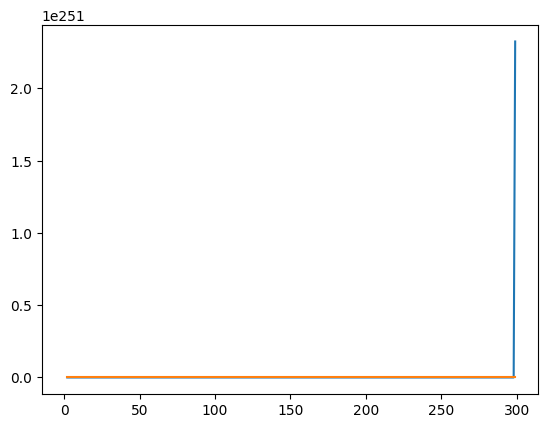

In [137]:
import deepxde as dde
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

t = np.arange(0,300)

def getAlpha(t):
    alpha = 0.1
    if t < 60 or 120 <= t < 180 or 240 <= t <= 300:
        alpha = 0.5
    elif 60 <= t < 120:
        alpha = 0.46
    elif 180 <= t < 240:
        alpha = 0.54
    return alpha

def modelSys(z,t):
    m,p = z
    m_t = 2.6*(10^-3)*(1.5*8.5 - p)/2
    p_t = 40000*(m - getAlpha(t)*(0.38*100*np.sqrt(10))*np.sqrt(p - 5.0))/2
    return [m_t, p_t]

z0 = [0,0]

z = odeint(modelSys, z0, t)

plt.plot(t,z[:,0],label='m(t)')
plt.plot(t,z[:,1],label='p(t)')
plt.show

In [ ]:
geom = dde.geometry.TimeDomain(0,300) # O sistema irá variar de 0 a 300 segundos

def sistema_EDO(x,y): # Função que retorna os valores da EDO
    m, PP = y[:, 0:1],y[:,1:]
    dm_t = dde.grad.jacobian(y,x,i=0)
    dPP_t = dde.grad.jacobian(y,x,i=1)
    return [dm_t - 2.6*(10^-3)*(1.5*8.5 - PP)/2, 
            dPP_t - 200^2*(m - getAlpha(x)*(0.38/((10^-5)^0.5))*np.sqrt(PP - 5.0))/2]

def boundary(_, on_initial):
    return on_initial

ic = dde.icbc.IC(geom, lambda x: 0, boundary)

net = dde.nn.FNN([1] + [30]*4 + [2], 'tanh', 'Glorto uniform')

